In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import random
from scipy.optimize import minimize
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
import time

## Params

In [2]:
############# Parameters ###############
params = {'input':2,
          'output':1,
          'N':50,
          'lr':0.0003,
          'rho':10e-5,
          'seed':1836702,
          'n_folds':5,
          'epoch':300,
          'method': "BFGS"}

## DataLoader

In [3]:
def load_dataset():
    data = pd.read_excel('dataPoints.xlsx')
    X, y = data[['x1','x2']], data[['y']]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
 
    return X_train, y_train, X_test, y_test
  
X_train, y_train, X_test, y_test = load_dataset()

## Models

In [4]:
class Adam:
    '''
    Implementation of Adam opt
    '''
    def __init__(self, learning_rate):
        self.__learning_rate = learning_rate
        self.__t = 0
        self.__alpha = 0.9
        self.__alpha2 = 0.999

    def optimize(self, vars):
        n_vars = len(vars)

        if not hasattr(self, '_Adam__r'):
            self.__s = [0] * n_vars
            self.__r = [0] * n_vars

        self.__t += 1

        v = [0] * n_vars
        for i in range(n_vars):
            self.__s[i] = self.__alpha * self.__s[i] + (1 - self.__alpha) * vars[i]
            s_hat = self.__s[i] / (1 - self.__alpha ** self.__t)
            self.__r[i] = self.__alpha2 * self.__r[i] + (1 - self.__alpha2) * np.power(vars[i], 2)
            r_hat = self.__r[i] / (1 - self.__alpha2 ** self.__t)
            v[i] = self.__learning_rate * s_hat / (1e-8 + np.sqrt(r_hat))
        return  v

In [5]:
class RBFN(object):

    def __init__(self, hidden_shape, sigma=1.0, regularization_factor = 0.001, verbose = True, supervised = True):
        self.__hidden_shape = hidden_shape
        self.__sigma = sigma
        self.__regularization_factor = regularization_factor
        self.__supervised = supervised
        self.__centers = None
        self.__weights = None
        self.__data = None

    def _kernel_function(self, center, data_point):
        return np.exp(-self.__sigma*np.linalg.norm(center-data_point)**2)

    def _calculate_interpolation_matrix(self, X):
        G = np.zeros((len(X), self.__hidden_shape))
        for data_point_arg, data_point in enumerate(X):
            for center_arg, center in enumerate(self.__centers):
                G[data_point_arg, center_arg] = self.__regularization_factor*self._kernel_function(center, data_point)
        return G

    def _select_centers(self, X):
        random_args = np.random.choice(len(X), self.__hidden_shape)
        centers = X[random_args]
        return centers

    def fit(self, X, Y):
        self.__data = X
        ## select centers
        if self.__supervised:
            model = KMeans(n_clusters=self.__hidden_shape, random_state=0)
            model.fit(X)
            self.__centers = model.cluster_centers_    ## Centers choosen by KMeans _ supervised
        else:
            self.__centers = self._select_centers(X) ## Randomly select centers _ unsupervised
        G = self._calculate_interpolation_matrix(X)
        self.__weights = np.dot(np.linalg.pinv(G), Y)

    def predict(self, X):
        G = self._calculate_interpolation_matrix(X)
        predictions = np.dot(G, self.__weights)
        return predictions

    def _func(self, x1, x2):
        y = []
        for i in x1:
            y_sub = []
            for j in x2:
                x = np.hstack([i, j]).reshape(-1,2)
                G = self._calculate_interpolation_matrix(x)
                y_sub.append(np.dot(G, self.__weights)[0])
            y.append(y_sub)
        y = np.array(y)
        return y.transpose(2,0,1).reshape(-1,y.shape[1])
    
    def plotting(self, title = "Plotting of the function"):
        #create the object
        fig = plt.figure(figsize=(15,10))
        ax = plt.axes(projection='3d')
        #create the grid
        x1 = np.linspace(-2, 2, 100).reshape(-1,1) 
        x2 = np.linspace(-1, 1, 100).reshape(-1,1) 
        X1, X2 = np.meshgrid(x1, x2) #create the grid for the plot
        Y = self._func(x1, x2) #evaluate the function (note that X1, X2, Z are matrix)
        ax.plot_surface(X1, X2, Y, rstride=1, cstride=1, cmap='viridis', edgecolor='none')

        ax.set_xlabel('x1')
        ax.set_ylabel('x2')
        ax.set_zlabel('y')
        ax.set_title(title)
        plt.show()

# Prediction

In [6]:
print("\nHyperparameters --------------------------------------------------")
print("Number of neurons N: ", 50)
print("rho: ", params["rho"])
print("sigma: ", 1)

print("\nOptimization -----------------------------------------------------")

X, y = X_train.values, y_train.values
kfold = KFold(params['n_folds'], random_state = 42, shuffle = True)
train_losses = []
val_losses = []
models = []

start = time.time()
for k_fold, (tr_inds, val_inds) in enumerate(kfold.split(X)):
    random.seed(params['seed']+k_fold)
    print("----Fold no: {}-------".format(k_fold+1))
    tr_x, tr_y = X[tr_inds], y[tr_inds]
    val_x, val_y = X[val_inds], y[val_inds]

    model = RBFN(params['N'])
    model.fit(tr_x, tr_y)
    
    models.append(model)
    
    ### predict on train again
    pred_tr = model.predict(tr_x)
    print("Train loss this fold: {}".format(mean_squared_error(pred_tr, tr_y)))
    train_losses.append(mean_squared_error(pred_tr, tr_y))
    
    ### validation 
    preds = model.predict(val_x)
    print("Val loss this fold: {}".format(mean_squared_error(preds, val_y)))
    val_losses.append(mean_squared_error(preds, val_y))
    
print("")
end = time.time()
print("time: {}".format((end-start) / params['n_folds']))

print("Train loss ave across all folds: {}".format(np.mean(train_losses)))
print("Val loss ave across all folds: {}".format(np.mean(val_losses)))

########### Prediction ############
print("*****************************")
print("------Prediction begins------")
for i in range(len(models)):
    if i == 0:
        pred = models[i].predict(X_test.values)
    else:
        pred += models[i].predict(X_test.values)
print("Final prediction error: {}".format(mean_squared_error(pred/params['n_folds'], y_test)))


Hyperparameters --------------------------------------------------
Number of neurons N:  50
rho:  0.0001
sigma:  1

Optimization -----------------------------------------------------
----Fold no: 1-------
Train loss this fold: 0.0023680870912269163
Val loss this fold: 0.005107198898252146
----Fold no: 2-------
Train loss this fold: 0.0016486058145311693
Val loss this fold: 0.007247932496518646
----Fold no: 3-------
Train loss this fold: 0.003192801914362025
Val loss this fold: 0.0032018679631107437
----Fold no: 4-------
Train loss this fold: 0.0014678027330734234
Val loss this fold: 0.016193366733812442
----Fold no: 5-------
Train loss this fold: 0.003051419428524752
Val loss this fold: 0.009395280922051193

time: 0.5637941837310791
Train loss ave across all folds: 0.0023457433963436575
Val loss ave across all folds: 0.008229129402749034
*****************************
------Prediction begins------
Final prediction error: 0.007830357883652198


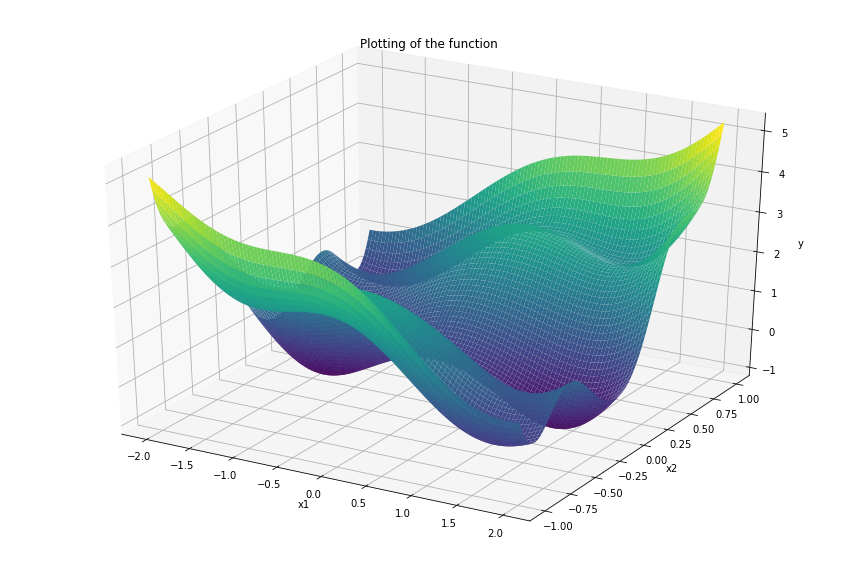

In [7]:
models[0].plotting()